#### Writing and Reading Time Series with TimeDB SDK

This notebook demonstrates:
1. Writing time series data without specifying series_id (auto-generated based on column name)
2. Reading data back and plotting with series metadata in legend
3. Writing multiple batches with the same series_id (extending a time series)
4. Discovering series by labels (e.g., filtering by turbine, site, or measurement type)

In [1]:
import timedb as td
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

# Load environment variables (for database connection)
from dotenv import load_dotenv
load_dotenv()


True

## Part 1: Two Different Time Series (Auto-Generated Series)

First, let's create the schema and write two different time series.
Each column in the DataFrame becomes a separate series with auto-generated series_id.

In [2]:
# Delete database schema
td.delete()

In [3]:
# Create database schema
td.create()

Creating database schema...
✓ Schema created successfully


In [4]:
# Create first time series: Wind power data (first 24 hours: 0-23)
base_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
dates1 = [base_time + timedelta(hours=i) for i in range(24)]
df1 = pd.DataFrame({
    'valid_time': dates1,
    'wind_power': [50.0 + i * 1.5 + (i % 6) * 5 for i in range(24)]  # MW, varying pattern
})

# Insert first time series (series_id will be auto-generated)
result1 = td.insert_batch(df=df1)
print(f"✓ Inserted first time series")
print(f"  Series name -> series_id mapping: {result1.series_ids}")
print(f"  Time range: {dates1[0]} to {dates1[-1]}")
print(f"  Value range: {df1['wind_power'].min():.1f} - {df1['wind_power'].max():.1f} MW")

Data values inserted successfully.
✓ Inserted first time series
  Series name -> series_id mapping: {'wind_power': UUID('ae0ccfab-41a8-4ec4-90d5-9f88190dca1e')}
  Time range: 2025-01-01 00:00:00+00:00 to 2025-01-01 23:00:00+00:00
  Value range: 50.0 - 109.5 MW


In [5]:
# Create second time series: Solar power data (next 24 hours: 24-47)
dates2 = [base_time + timedelta(hours=i) for i in range(24, 48)]  # Hours 24-47
# Solar has day/night pattern - peak at noon (hour 12 and 36)
df2 = pd.DataFrame({
    'valid_time': dates2,
    'solar_power': [max(0, 30.0 * (1 - abs((i % 24) - 12) / 12)) for i in range(24, 48)]  # MW, peaks at noon
})

# Insert second time series (series_id will be auto-generated)
result2 = td.insert_batch(df=df2)
print(f"✓ Inserted second time series")
print(f"  Series name -> series_id mapping: {result2.series_ids}")
print(f"  Time range: {dates2[0]} to {dates2[-1]}")
print(f"  Value range: {df2['solar_power'].min():.1f} - {df2['solar_power'].max():.1f} MW")

Data values inserted successfully.
✓ Inserted second time series
  Series name -> series_id mapping: {'solar_power': UUID('07a85687-17fc-445b-ad7b-a296b58aedcc')}
  Time range: 2025-01-02 00:00:00+00:00 to 2025-01-02 23:00:00+00:00
  Value range: 0.0 - 30.0 MW


In [6]:
# Read back all time series
df_read = td.read()
print(f"✓ Read {len(df_read)} rows")
print(f"\nDataFrame shape: {df_read.shape}")
print(f"\nColumns (series): {df_read.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_read.head(10))

✓ Read 48 rows

DataFrame shape: (48, 2)

Columns (series): ['solar_power', 'wind_power']

First few rows:
name                       solar_power  wind_power
valid_time                                        
2025-01-01 00:00:00+00:00          nan        50.0
2025-01-01 01:00:00+00:00          nan        56.5
2025-01-01 02:00:00+00:00          nan        63.0
2025-01-01 03:00:00+00:00          nan        69.5
2025-01-01 04:00:00+00:00          nan        76.0
2025-01-01 05:00:00+00:00          nan        82.5
2025-01-01 06:00:00+00:00          nan        59.0
2025-01-01 07:00:00+00:00          nan        65.5
2025-01-01 08:00:00+00:00          nan        72.0
2025-01-01 09:00:00+00:00          nan        78.5


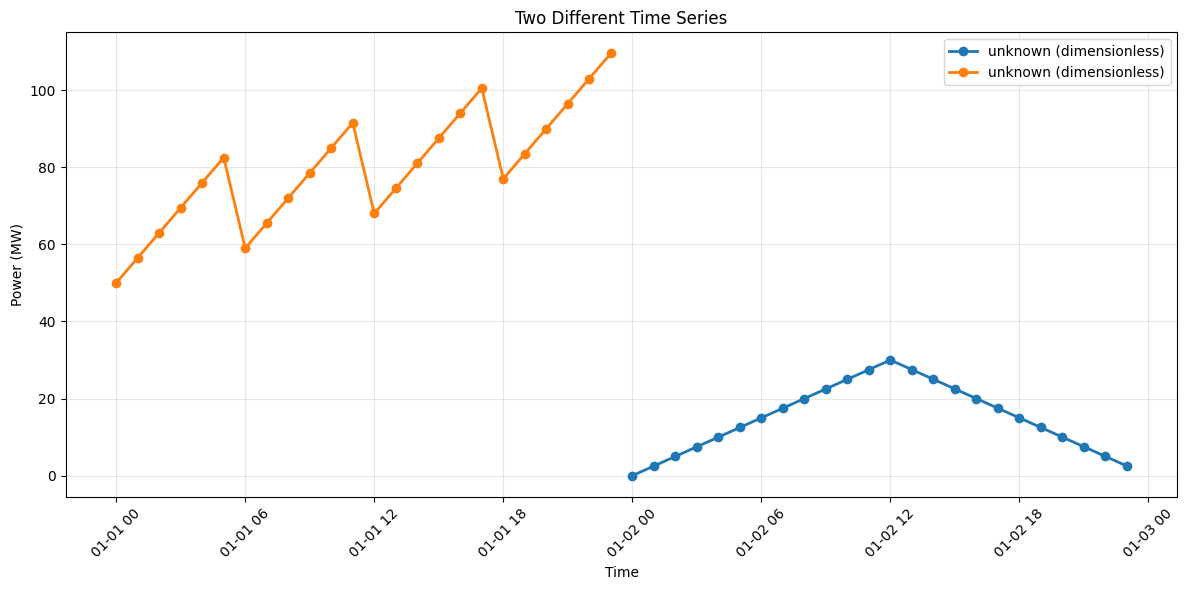


✓ Plotted 2 different time series


In [7]:
# Plot the time series
plt.figure(figsize=(12, 6))
for series_id in df_read.columns:
    # Get series metadata to use in legend
    name = df_read[series_id].attrs.get('name', 'unknown')
    unit = df_read[series_id].attrs.get('unit', 'dimensionless')
    
    # Extract numeric values (handle both plain floats and Pint quantities)
    values = df_read[series_id]
    try:
        # Try to extract magnitudes if Pint quantities
        plot_values = values.apply(lambda v: v.magnitude if hasattr(v, 'magnitude') and pd.notna(v) else (float('nan') if pd.isna(v) else v))
    except:
        # Fallback to raw values
        plot_values = values
    
    plt.plot(df_read.index, plot_values, marker='o', label=f'{name} ({unit})', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.title('Two Different Time Series')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n✓ Plotted {len(df_read.columns)} different time series")

## Part 2: Explicit Series IDs (Consolidated Time Series)

Now let's create a series with explicit metadata (name, unit, labels) and use the same series_id for multiple writes.
This demonstrates how to extend a time series over time.

In [8]:
# Delete schema to start fresh
td.delete()

# Create schema again
td.create()

Creating database schema...
✓ Schema created successfully


In [9]:
# Create a series with explicit metadata
import uuid

# Create a series with name, unit, and labels
shared_series_id = td.create_series(
    name='wind_power',
    unit='MW',
    labels={'turbine': 'T01', 'site': 'Site_A'},
    description='Wind power output from turbine T01 at Site A'
)
print(f"Created series with ID: {shared_series_id}")
print(f"  name='wind_power', unit='MW'")
print(f"  labels={{'turbine': 'T01', 'site': 'Site_A'}}")

Created series with ID: 1b7b1f04-b466-41e2-800e-0af2a5375f33
  name='wind_power', unit='MW'
  labels={'turbine': 'T01', 'site': 'Site_A'}


In [10]:
# Insert first batch of data with explicit series_id
df_batch1 = pd.DataFrame({
    'valid_time': dates1,
    'wind_power': [45.0 + i * 1.2 for i in range(24)]  # Gradual increase
})

result1 = td.insert_batch(df=df_batch1, series_ids={'wind_power': shared_series_id})
print(f"✓ Inserted first batch with series_id: {result1.series_ids['wind_power']}")
print(f"  Time range: {dates1[0]} to {dates1[-1]}")
print(f"  Value range: {df_batch1['wind_power'].min():.1f} - {df_batch1['wind_power'].max():.1f} MW")

Data values inserted successfully.
✓ Inserted first batch with series_id: 1b7b1f04-b466-41e2-800e-0af2a5375f33
  Time range: 2025-01-01 00:00:00+00:00 to 2025-01-01 23:00:00+00:00
  Value range: 45.0 - 72.6 MW


In [11]:
# Prepare second batch of data for the same series
df_batch2 = pd.DataFrame({
    'valid_time': dates2,
    'wind_power': [52.0 + i * 0.8 for i in range(24)]  # Different pattern
})

# Insert second batch with the SAME series_id
result2 = td.insert_batch(df=df_batch2, series_ids={'wind_power': shared_series_id})
print(f"✓ Inserted second batch with series_id: {result2.series_ids['wind_power']}")
print(f"  Time range: {dates2[0]} to {dates2[-1]}")
print(f"  Value range: {df_batch2['wind_power'].min():.1f} - {df_batch2['wind_power'].max():.1f} MW")
print(f"  Same series_id: {result1.series_ids['wind_power'] == result2.series_ids['wind_power']}")
print(f"  → The two batches are consolidated into one continuous time series!")

Data values inserted successfully.
✓ Inserted second batch with series_id: 1b7b1f04-b466-41e2-800e-0af2a5375f33
  Time range: 2025-01-02 00:00:00+00:00 to 2025-01-02 23:00:00+00:00
  Value range: 52.0 - 70.4 MW
  Same series_id: True
  → The two batches are consolidated into one continuous time series!


In [12]:
# Read back the consolidated time series
df_read = td.read()
print(f"✓ Read {len(df_read)} rows")
print(f"\nDataFrame shape: {df_read.shape}")
print(f"\nColumns (series_ids): {df_read.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_read.head(10))
print(f"\nLast few rows:")
print(df_read.tail(10))

✓ Read 48 rows

DataFrame shape: (48, 1)

Columns (series_ids): ['wind_power']

First few rows:
name                       wind_power
valid_time                           
2025-01-01 00:00:00+00:00        45.0
2025-01-01 01:00:00+00:00        46.2
2025-01-01 02:00:00+00:00        47.4
2025-01-01 03:00:00+00:00        48.6
2025-01-01 04:00:00+00:00        49.8
2025-01-01 05:00:00+00:00        51.0
2025-01-01 06:00:00+00:00        52.2
2025-01-01 07:00:00+00:00        53.4
2025-01-01 08:00:00+00:00        54.6
2025-01-01 09:00:00+00:00        55.8

Last few rows:
name                       wind_power
valid_time                           
2025-01-02 14:00:00+00:00        63.2
2025-01-02 15:00:00+00:00        64.0
2025-01-02 16:00:00+00:00        64.8
2025-01-02 17:00:00+00:00        65.6
2025-01-02 18:00:00+00:00        66.4
2025-01-02 19:00:00+00:00        67.2
2025-01-02 20:00:00+00:00        68.0
2025-01-02 21:00:00+00:00        68.8
2025-01-02 22:00:00+00:00        69.6
2025-01-02 23:

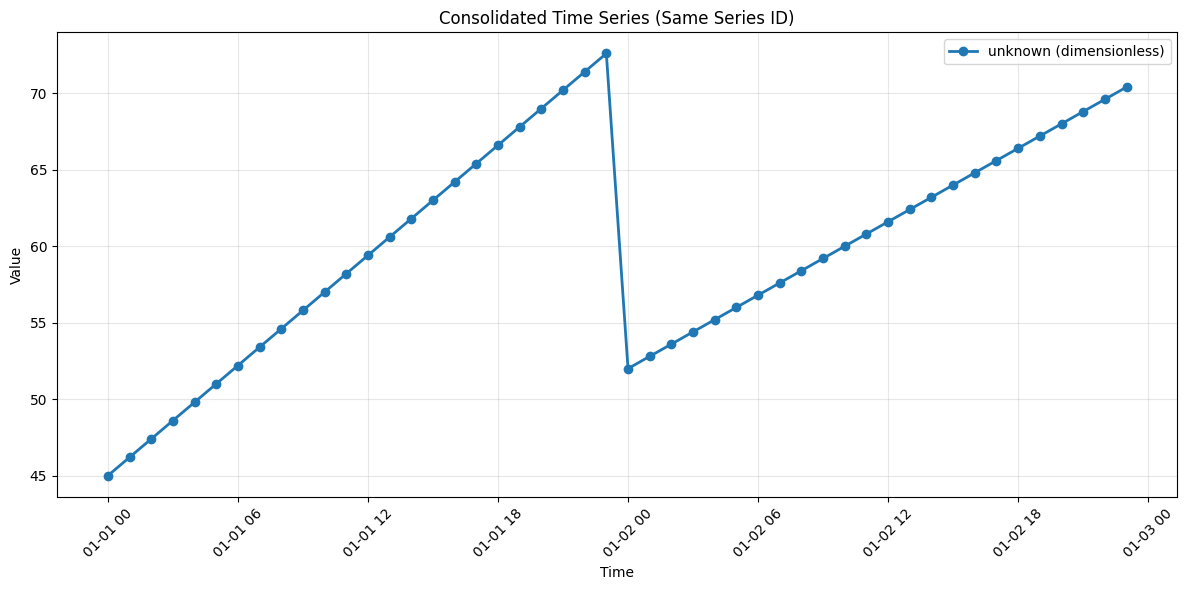


✓ Plotted 1 time series
  Both batches used the same series_id → one consolidated time series spanning 48 hours


In [13]:
# Plot the consolidated time series
plt.figure(figsize=(12, 6))
for series_id in df_read.columns:
    # Get series metadata from attrs
    name = df_read[series_id].attrs.get('name', 'unknown')
    unit = df_read[series_id].attrs.get('unit', 'dimensionless')
    labels = df_read[series_id].attrs.get('labels', {})
    
    # Build a descriptive label
    label_str = ', '.join([f"{k}={v}" for k, v in labels.items()])
    legend_label = f'{name} ({unit}) [{label_str}]' if label_str else f'{name} ({unit})'
    
    # Extract numeric values (handle both plain floats and Pint quantities)
    values = df_read[series_id]
    try:
        # Try to extract magnitudes if Pint quantities
        plot_values = values.apply(lambda v: v.magnitude if hasattr(v, 'magnitude') and pd.notna(v) else (float('nan') if pd.isna(v) else v))
    except:
        # Fallback to raw values
        plot_values = values
    
    plt.plot(df_read.index, plot_values, marker='o', label=legend_label, linewidth=2)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Consolidated Time Series (Same Series ID)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n✓ Plotted {len(df_read.columns)} time series")
print(f"  Both batches used the same series_id → one consolidated time series spanning 48 hours")

## Part 3: Discovering Series with get_mapping()

The new `get_mapping()` function allows you to discover series based on their metadata (name, unit, labels).
Let's create multiple series with different labels to demonstrate various filtering capabilities.

In [14]:
# First, let's create a fresh database with multiple series
td.delete()
td.create()

# Create multiple series with different labels
series_configs = [
    # Wind turbines at different sites
    {'name': 'wind_power', 'unit': 'MW', 'labels': {'turbine': 'T01', 'site': 'Site_A', 'type': 'wind'}},
    {'name': 'wind_power', 'unit': 'MW', 'labels': {'turbine': 'T02', 'site': 'Site_A', 'type': 'wind'}},
    {'name': 'wind_power', 'unit': 'MW', 'labels': {'turbine': 'T01', 'site': 'Site_B', 'type': 'wind'}},
    {'name': 'wind_power', 'unit': 'MW', 'labels': {'turbine': 'T02', 'site': 'Site_B', 'type': 'wind'}},
    
    # Solar installations
    {'name': 'solar_power', 'unit': 'MW', 'labels': {'panel_id': 'P01', 'site': 'Site_A', 'type': 'solar'}},
    {'name': 'solar_power', 'unit': 'MW', 'labels': {'panel_id': 'P02', 'site': 'Site_B', 'type': 'solar'}},
    
    # Temperature sensors
    {'name': 'temperature', 'unit': 'degC', 'labels': {'sensor': 'S01', 'site': 'Site_A'}},
    {'name': 'temperature', 'unit': 'degC', 'labels': {'sensor': 'S02', 'site': 'Site_B'}},
]

# Create all series and store their IDs
series_ids = {}
for config in series_configs:
    series_id = td.create_series(
        name=config['name'],
        unit=config['unit'],
        labels=config['labels'],
        description=f"{config['name']} at {config['labels'].get('site', 'unknown')}"
    )
    key = f"{config['name']}_{list(config['labels'].values())[0]}"
    series_ids[key] = series_id

print(f"✓ Created {len(series_ids)} series with various labels")
print(f"  Wind power series: {sum(1 for k in series_ids if 'wind_power' in k)}")
print(f"  Solar power series: {sum(1 for k in series_ids if 'solar_power' in k)}")
print(f"  Temperature series: {sum(1 for k in series_ids if 'temperature' in k)}")

Creating database schema...
✓ Schema created successfully
✓ Created 6 series with various labels
  Wind power series: 2
  Solar power series: 2
  Temperature series: 2


In [15]:
# Example 1: Get ALL series in the database
all_series = td.get_mapping()
print(f"1. All series in database: {len(all_series)}")
for label_set, series_id in all_series.items():
    labels = dict(label_set)
    print(f"   {labels} -> {series_id}")

1. All series in database: 8
   {'type': 'solar', 'panel_id': 'P02', 'site': 'Site_B'} -> bf88bdeb-ea0e-4492-b389-06080fa3c57b
   {'type': 'solar', 'panel_id': 'P01', 'site': 'Site_A'} -> eafad25c-bfdf-4457-b1c7-035620722be4
   {'sensor': 'S01', 'site': 'Site_A'} -> 016152e8-075c-48c3-ab3e-279811acee6a
   {'site': 'Site_B', 'sensor': 'S02'} -> 97f6ae5f-2081-4e95-924b-acdb2726f7eb
   {'type': 'wind', 'turbine': 'T02', 'site': 'Site_B'} -> 1dd7b87d-1da1-45a8-bc7e-4d344e53811a
   {'type': 'wind', 'site': 'Site_A', 'turbine': 'T01'} -> 71008a23-4b0e-41ea-bd43-801abb74996a
   {'type': 'wind', 'site': 'Site_A', 'turbine': 'T02'} -> 89496bd2-7a71-4cc7-aacc-3a05de6f78a6
   {'type': 'wind', 'turbine': 'T01', 'site': 'Site_B'} -> ea912f83-84d0-4e8b-8c52-b59a979ae40f


In [16]:
# Example 2: Filter by name (all wind power series)
wind_series = td.get_mapping(name='wind_power')
print(f"\n2. All wind_power series: {len(wind_series)}")
for label_set, series_id in wind_series.items():
    labels = dict(label_set)
    print(f"   Turbine {labels['turbine']} at {labels['site']} -> {series_id}")


2. All wind_power series: 4
   Turbine T02 at Site_B -> 1dd7b87d-1da1-45a8-bc7e-4d344e53811a
   Turbine T01 at Site_A -> 71008a23-4b0e-41ea-bd43-801abb74996a
   Turbine T02 at Site_A -> 89496bd2-7a71-4cc7-aacc-3a05de6f78a6
   Turbine T01 at Site_B -> ea912f83-84d0-4e8b-8c52-b59a979ae40f


In [17]:
# Example 3: Filter by single label (all series at Site_A)
site_a_series = td.get_mapping(label_filter={'site': 'Site_A'})
print(f"\n3. All series at Site_A: {len(site_a_series)}")
for label_set, series_id in site_a_series.items():
    labels = dict(label_set)
    print(f"   {labels} -> {series_id}")


3. All series at Site_A: 4
   {'type': 'solar', 'panel_id': 'P01', 'site': 'Site_A'} -> eafad25c-bfdf-4457-b1c7-035620722be4
   {'sensor': 'S01', 'site': 'Site_A'} -> 016152e8-075c-48c3-ab3e-279811acee6a
   {'type': 'wind', 'site': 'Site_A', 'turbine': 'T01'} -> 71008a23-4b0e-41ea-bd43-801abb74996a
   {'type': 'wind', 'site': 'Site_A', 'turbine': 'T02'} -> 89496bd2-7a71-4cc7-aacc-3a05de6f78a6


In [18]:
# Example 4: Filter by label value (all wind type series)
wind_type_series = td.get_mapping(label_filter={'type': 'wind'})
print(f"\n4. All series with type='wind': {len(wind_type_series)}")
for label_set, series_id in wind_type_series.items():
    labels = dict(label_set)
    print(f"   {labels['turbine']} at {labels['site']} -> {series_id}")


4. All series with type='wind': 4
   T02 at Site_B -> 1dd7b87d-1da1-45a8-bc7e-4d344e53811a
   T01 at Site_A -> 71008a23-4b0e-41ea-bd43-801abb74996a
   T02 at Site_A -> 89496bd2-7a71-4cc7-aacc-3a05de6f78a6
   T01 at Site_B -> ea912f83-84d0-4e8b-8c52-b59a979ae40f


In [19]:
# Example 5: Filter by multiple labels (turbine T01 at Site_A)
specific_turbine = td.get_mapping(label_filter={'turbine': 'T01', 'site': 'Site_A'})
print(f"\n5. Series matching turbine='T01' AND site='Site_A': {len(specific_turbine)}")
for label_set, series_id in specific_turbine.items():
    labels = dict(label_set)
    print(f"   Full labels: {labels}")
    print(f"   Series ID: {series_id}")


5. Series matching turbine='T01' AND site='Site_A': 1
   Full labels: {'type': 'wind', 'site': 'Site_A', 'turbine': 'T01'}
   Series ID: 71008a23-4b0e-41ea-bd43-801abb74996a


In [20]:
# Example 6: Combine name + unit + labels for exact match
exact_match = td.get_mapping(
    name='wind_power',
    unit='MW',
    label_filter={'turbine': 'T01', 'site': 'Site_A', 'type': 'wind'}
)
print(f"\n6. Exact match (wind_power in MW, turbine T01 at Site_A): {len(exact_match)}")
for label_set, series_id in exact_match.items():
    labels = dict(label_set)
    print(f"   Full labels: {labels}")
    print(f"   Series ID: {series_id}")
    print(f"   ✓ This uniquely identifies one specific series")


6. Exact match (wind_power in MW, turbine T01 at Site_A): 1
   Full labels: {'type': 'wind', 'site': 'Site_A', 'turbine': 'T01'}
   Series ID: 71008a23-4b0e-41ea-bd43-801abb74996a
   ✓ This uniquely identifies one specific series
